In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from NCP.utils import FastTensorDataLoader
from torch.optim import Adam
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10

import matplotlib.pyplot as plt
from scipy.stats import norm
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP, ConvMLP
from NCP.nn.losses import CMELoss
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks.model_checkpoint import ModelCheckpoint

class CustomModelCheckpoint(ModelCheckpoint):
    def on_save_checkpoint(self, trainer, pl_module, checkpoint):
        X, Y = trainer.model.batch
        trainer.model.model._compute_data_statistics(X, Y)

def restore_buffers_shape(model, state_dict):
    model._sing_val = torch.zeros_like(state_dict['model._sing_val']).to('cpu')
    model._sing_vec_l = torch.zeros_like(state_dict['model._sing_vec_l']).to('cpu')
    model._sing_vec_r = torch.zeros_like(state_dict['model._sing_vec_r']).to('cpu')

from NCP.examples.tools.plot_utils import setup_plots
setup_plots()

np.random.seed(0)
torch.manual_seed(0)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
L.seed_everything(0)

Seed set to 0


0

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float32),
     transforms.Normalize((0.5), (0.5))])

def tofl32(x):
    return torch.Tensor([x]).type(torch.float32)
target_transform = transforms.Compose([transforms.Lambda(tofl32)])

In [9]:
batch_size = 64

trainset = MNIST(root='./data', train=True,
                download=True, transform=transform, target_transform=target_transform)
trainloader = FastTensorDataLoader(trainset.data.type(torch.float32)[:, None, :, :], 
                                   trainset.targets.type(torch.float32)[:, None], 
                                   batch_size=batch_size)

testset = MNIST(root='./data', train=False,
                download=True, transform=transform, target_transform=target_transform)

X_test = trainset.data.type(torch.float32)[:, None, :, :]
Y_test = trainset.targets.type(torch.float32)[:, None]

In [6]:
data = next(iter(trainloader))
print(data[0].size())
print(data[1].size())
input_shape = data[0].size()[-1]
label_shape = data[1].size()[-1]

torch.Size([64, 1, 28, 28])
torch.Size([64, 1])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 999: 100%|██████████| 938/938 [00:11<00:00, 78.82it/s, v_num=15, train_loss=-4.76]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 999: 100%|██████████| 938/938 [00:11<00:00, 78.80it/s, v_num=15, train_loss=-4.76]


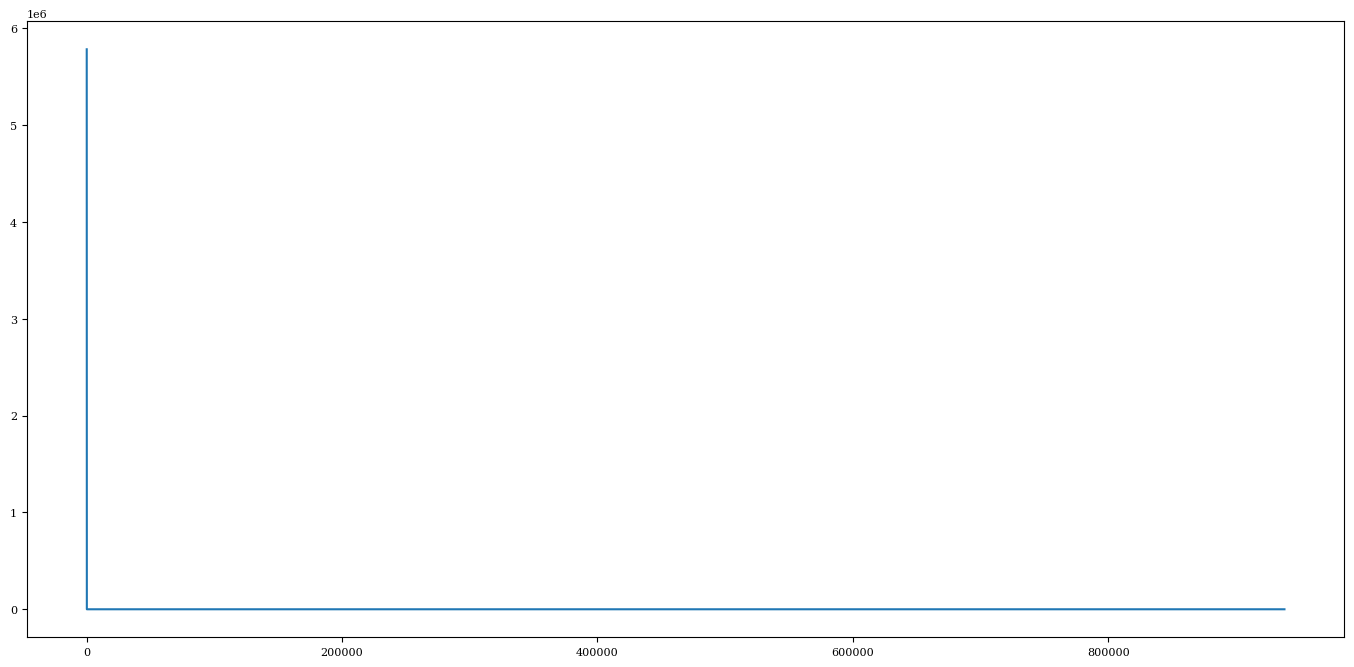

In [8]:
lr = 1e-3
gamma = 1e-2
epochs = int(1e3)
output_shape = 100

MLP_kwargs_U = {
    'rgb': False,
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

MLP_kwargs_V = {
    'input_shape': label_shape,
    'output_shape': output_shape,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=ConvMLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

early_stop = EarlyStopping(monitor="train_loss", patience=1000, mode="min")
checkpoint_callback = CustomModelCheckpoint(save_top_k=1, monitor="train_loss", mode="min")

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
    'enable_checkpointing': True,
    'num_sanity_val_steps': 0,
    'enable_model_summary': False,
    }, callbacks=[early_stop, checkpoint_callback])

trainer.fit(NCP_module, train_dataloaders=trainloader)

# recover best model during training
best_model_dict = torch.load(checkpoint_callback.best_model_path)
restore_buffers_shape(reg, best_model_dict['state_dict'])
NCP_module.load_state_dict(best_model_dict['state_dict'])
best_model = NCP_module.model

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

In [ ]:
def get_proba(model, sample, classes, Y_sampling, postprocess='whitening'):
    condprobas = np.zeros(len(classes))
    for i, c in classes:
        # observable is a vector to scalar function
        fY = torch.stack([int(y_i == c) for y_i in torch.unbind(Y_sampling, dim=-1)], dim=-1).flatten() # Pytorch equivalent of numpy.apply_along_axis
        proba = torch.sum(fY, -1) / fY.shape[0]  # vector of [k/n], k \in [n]

        Ux, sigma, Vy = model.postprocess_UV(sample, Y_sampling, postprocess)
        Ux = Ux.flatten()

        # estimating the cdf of the function f on X_t
        Ify = torch.outer(fY, torch.ones(Vy.shape[1]))  # indicator function of fY < fY[i], put into shape (n_sample, latent_dim)
        EVyFy = torch.mean(Vy * Ify, axis=0)  # for all latent dim, compute E (Vy * fY)
        condprobas[i] = proba[i] + torch.sum(sigma * Ux * EVyFy)

    return condprobas

def is_in_interval(condprobas, classes, true_label, alpha):
    sorted_probas = np.argsort(condprobas)
    coverages = np.cumsum(condprobas[sorted_probas])
    classes_in_coverage = classes[sorted_probas][coverages > alpha]
    return true_label in classes_in_coverage

#for all values in test set,

# compute probas for all classes

# measure coverage?

True target: tensor([5.])


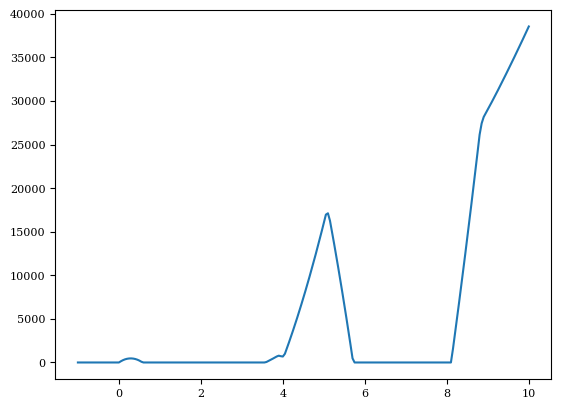

In [15]:
Y_discr = np.linspace(-1, 10, 221) # contains the true values of the classes

fys, pdf_pred = best_model.pdf(X_test[0][None,:,:,:], torch.Tensor(Y_discr)[:,None], postprocess='centering')

print('True target:', Y_test[0])
plt.plot(fys, np.maximum(pdf_pred, 0))

True target: tensor([0.])


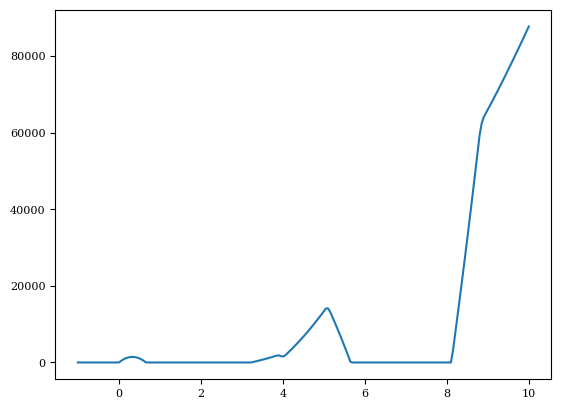

In [16]:
Y_discr = np.linspace(-1, 10, 221) # contains the true values of the classes

fys, pdf_pred = best_model.pdf(X_test[1][None,:,:,:], torch.Tensor(Y_discr)[:,None], postprocess='centering')

print('True target:', Y_test[1])
plt.plot(fys, np.maximum(pdf_pred, 0))

True target: tensor([4.])


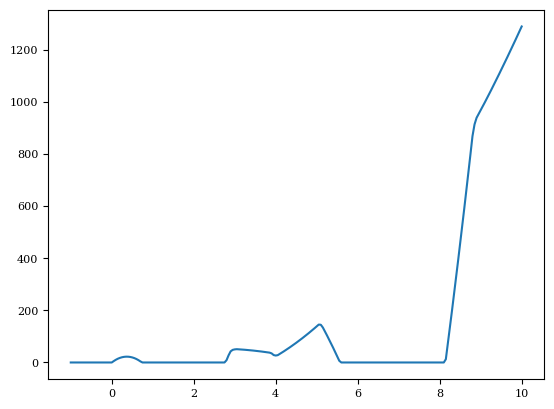

In [17]:
Y_discr = np.linspace(-1, 10, 221) # contains the true values of the classes

fys, pdf_pred = best_model.pdf(X_test[2][None,:,:,:], torch.Tensor(Y_discr)[:,None], postprocess='centering')

print('True target:', Y_test[2])
plt.plot(fys, np.maximum(pdf_pred, 0))

# CIFAR 10

In [ ]:
batch_size = 4

trainset = CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:07<00:00, 22624532.99it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
lr = 1e-3
gamma = 1e-2
epochs = int(1e4)
output_shape = 100

MLP_kwargs_U = {
    'rgb': False,
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

MLP_kwargs_V = {
    'input_shape': input_shape,
    'output_shape': output_shape,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

torch.Size([4, 3, 32, 32])

In [ ]:
optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=ConvMLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)